In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [66]:
#load the mnist dataset
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

In [67]:
#create train and test loaders
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

In [4]:
#create a cnn architecture
class Teacher_CNN(nn.Module):
    def __init__(self):
        super(Teacher_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64*5*5, 128)
        self.fc2 = nn.Linear(128, 10)
        #add softmax
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 64*5*5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [5]:
#create the model
teacher_model = Teacher_CNN()
teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)
teacher_loss = nn.CrossEntropyLoss()

In [6]:
def train_model(model, train_dataloader, test_dataloader, optimizer, loss_fn, num_epochs, CUDA=False, print_accs=True):

    traing_accs = []
    test_accs = []

    for epoch in range(1, num_epochs+1):
        
        model.train()
        # Write training loop here
        for i, (X, y) in enumerate(train_dataloader):
            
            if CUDA:
                X = X.cuda()
                y = y.cuda()

            optimizer.zero_grad()
            y_pred = model(X)
            
            loss = loss_fn(y_pred, y)
            
            loss.backward()
            optimizer.step()

        # Write evaluation loop(s) here
        
        # Calculate training accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in train_dataloader:
                if CUDA:
                    X = X.cuda()
                    y = y.cuda()

                y_pred = model(X)
                
                _, predicted = torch.max(y_pred.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
                
        #print(f"Epoch {epoch}, Training Accuracy: {correct / total}")
        traing_accs.append(correct / total)
        
        # Calculate test accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in test_dataloader:
                if CUDA:
                    X = X.cuda()
                    y = y.cuda()

                y_pred = model(X)
                
                _, predicted = torch.max(y_pred.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
                
        #print(f"Epoch {epoch}, Accuracy: {correct / total}")
        if print_accs:
            print(f"Epoch {epoch}, Training Accuracy: {traing_accs[-1]}, Validation Accuracy: {correct / total}")
        
        test_accs.append(correct / total)
        # Do not forget to use model.train() and model.eval() before training and evaluation loops respectively.
    return traing_accs, test_accs
    

In [7]:
#train the teacher model
traing_accs, test_accs = train_model(teacher_model, train_loader, test_loader, teacher_optimizer, teacher_loss, 5)

Epoch 1, Training Accuracy: 0.9693666666666667, Validation Accuracy: 0.9737
Epoch 2, Training Accuracy: 0.9829, Validation Accuracy: 0.9839
Epoch 3, Training Accuracy: 0.9849166666666667, Validation Accuracy: 0.9844
Epoch 4, Training Accuracy: 0.9880333333333333, Validation Accuracy: 0.9865
Epoch 5, Training Accuracy: 0.9899333333333333, Validation Accuracy: 0.9892


In [8]:
#Create a new dataset with the teacher model predictions
teacher_model.eval()
teacher_input = []
teacher_predicted_probailities = []
with torch.no_grad():
    for X, y in train_loader:
        y_pred = teacher_model(X)
        teacher_input.append(X)
        teacher_predicted_probailities.append(y_pred)
        
teacher_input = torch.cat(teacher_input)
teacher_predicted_probailities = torch.cat(teacher_predicted_probailities)

In [9]:
#create new dataset
teacher_dataset = torch.utils.data.TensorDataset(teacher_input, teacher_predicted_probailities)
teacher_loader = torch.utils.data.DataLoader(teacher_dataset, batch_size=100, shuffle=True)

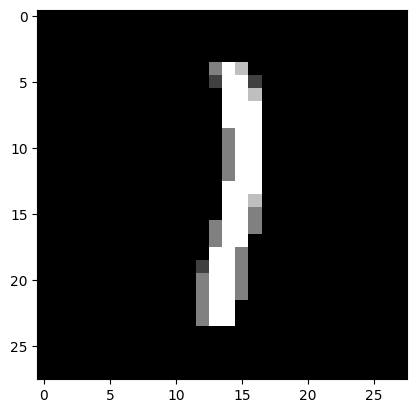

In [10]:
#plot the first image
plt.imshow(teacher_input[0].squeeze().numpy(), cmap='gray')
plt.show()

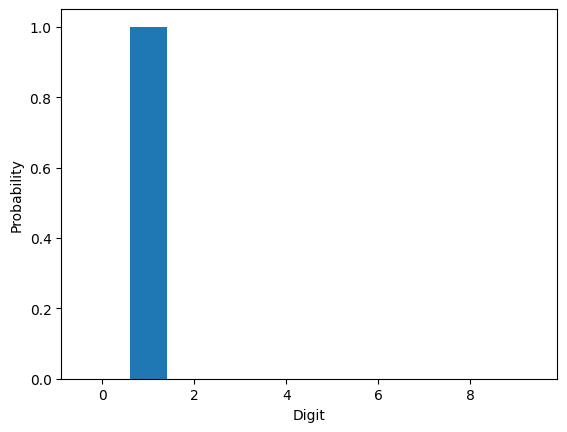

In [11]:
#plot the first image probabilities
plt.bar(range(10), teacher_predicted_probailities[0].numpy())
plt.xlabel('Digit')
plt.ylabel('Probability')
plt.show()

In [12]:
#create student model
student_model = Teacher_CNN()
student_optimizer = optim.Adam(student_model.parameters(), lr=0.001)
student_loss = nn.CrossEntropyLoss()

In [13]:
def train_model_student(model, train_dataloader, test_dataloader, optimizer, loss_fn, num_epochs, CUDA=False, print_accs=True):

    traing_accs = []
    test_accs = []

    for epoch in range(1, num_epochs+1):
        
        model.train()
        # Write training loop here
        for i, (X, y) in enumerate(train_dataloader):
            
            if CUDA:
                X = X.cuda()
                y = y.cuda()

            optimizer.zero_grad()
            y_pred = model(X)
            
            loss = loss_fn(y_pred, y)
            
            loss.backward()
            optimizer.step()

        # Write evaluation loop(s) here
        
        # Calculate training accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in train_dataloader:
                if CUDA:
                    X = X.cuda()
                    y = y.cuda()

                y_pred = model(X)
                
                _, predicted = torch.max(y_pred.data, 1)
                _, true_classes = torch.max(y, dim=1)
                
                total += y.size(0)
                correct += (predicted == true_classes).sum().item()
                
        #print(f"Epoch {epoch}, Training Accuracy: {correct / total}")
        traing_accs.append(correct / total)
        
        # Calculate test accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in test_dataloader:
                if CUDA:
                    X = X.cuda()
                    y = y.cuda()

                y_pred = model(X)
                
                _, predicted = torch.max(y_pred.data, 1)
                
                total += y.size(0)
                correct += (predicted == y).sum().item()
                
        #print(f"Epoch {epoch}, Accuracy: {correct / total}")
        if print_accs:
            print(f"Epoch {epoch}, Training Accuracy: {traing_accs[-1]}, Validation Accuracy: {correct / total}")
        
        test_accs.append(correct / total)
        # Do not forget to use model.train() and model.eval() before training and evaluation loops respectively.
    return traing_accs, test_accs
    

In [14]:
#create random tensor
random_tensor = torch.rand(10, 2)
print(random_tensor)
a, b = torch.max(random_tensor, 1)

print(a,b)

tensor([[0.9116, 0.8512],
        [0.9764, 0.7353],
        [0.6192, 0.9409],
        [0.0120, 0.9613],
        [0.4433, 0.8698],
        [0.9519, 0.2451],
        [0.8287, 0.7020],
        [0.5307, 0.4282],
        [0.3262, 0.2561],
        [0.2428, 0.6277]])
tensor([0.9116, 0.9764, 0.9409, 0.9613, 0.8698, 0.9519, 0.8287, 0.5307, 0.3262,
        0.6277]) tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 1])


In [15]:
#train the student model
traing_accs, test_accs = train_model_student(student_model, teacher_loader, test_loader, student_optimizer, student_loss, 5)

Epoch 1, Training Accuracy: 0.9774666666666667, Validation Accuracy: 0.9766
Epoch 2, Training Accuracy: 0.9782666666666666, Validation Accuracy: 0.972
Epoch 3, Training Accuracy: 0.9881333333333333, Validation Accuracy: 0.982
Epoch 4, Training Accuracy: 0.9907833333333333, Validation Accuracy: 0.9857
Epoch 5, Training Accuracy: 0.9859833333333333, Validation Accuracy: 0.9785


In [16]:
from fgsm import create_fgsm_adversarial_example
from fgsm import can_import

In [19]:
can_import()

FGSM file can import!


Text(0.5, 1.0, 'True Label: 5')

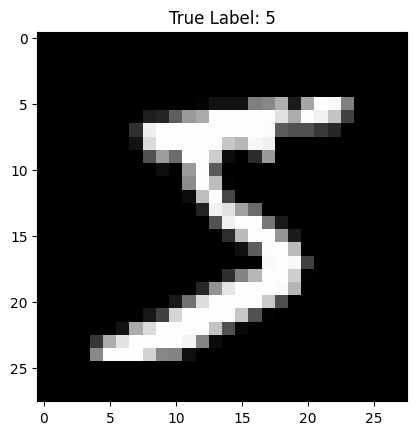

In [17]:
#plot the first image from the studnet dataset

im = train_loader.dataset[0][0].squeeze().numpy()
label = train_loader.dataset[0][1]
plt.imshow(im, cmap='gray')
plt.title(f'True Label: {label}')

In [25]:
def create_fgsm_adversarial_example(model, criterion, X, y, epsilon):
    X.requires_grad = True
    model.zero_grad()
    output = model(X)
    model_prediction_unperturbed = output.argmax(dim=1)
    prediction_confidence = F.softmax(output, dim=1).max()
    loss = criterion(output, y)
    loss.backward()
    x_grad = X.grad.data
    x_adv = X + epsilon * x_grad.sign()
    return model_prediction_unperturbed, prediction_confidence, x_adv

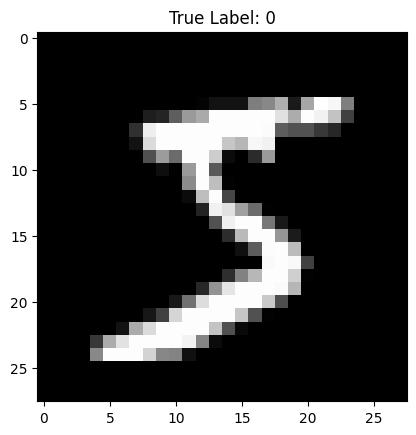

In [74]:
#create an adversarial example
input_label = train_loader.dataset[1][1]

#convert y to tensor
y_tensor = torch.tensor([input_label])

model_prediction_unperturbed, prediction_confidence, x_adv = create_fgsm_adversarial_example(teacher_model, teacher_loss, train_loader.dataset[1][0], y_tensor, epsilon=0.3)


#plot the orginal image
plt.imshow(train_loader.dataset[0][0].squeeze().numpy(), cmap='gray')
plt.title(f'True Label: {input_label}')
plt.show()

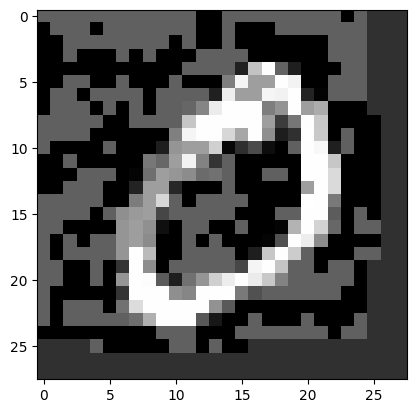

In [75]:
#plot the adversarial image
plt.imshow(x_adv.squeeze().detach().numpy(), cmap='gray')

In [76]:
print(x_adv.shape)

torch.Size([1, 28, 28])


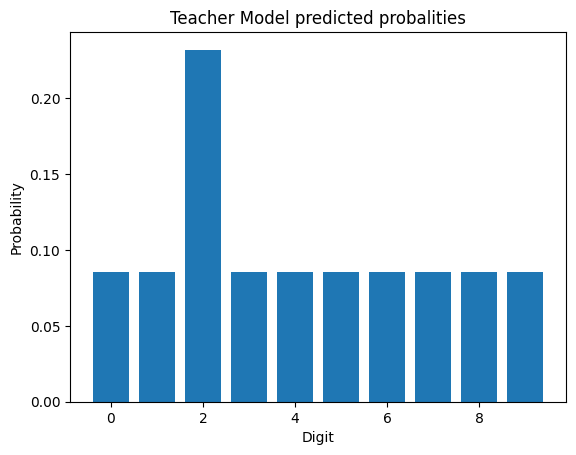

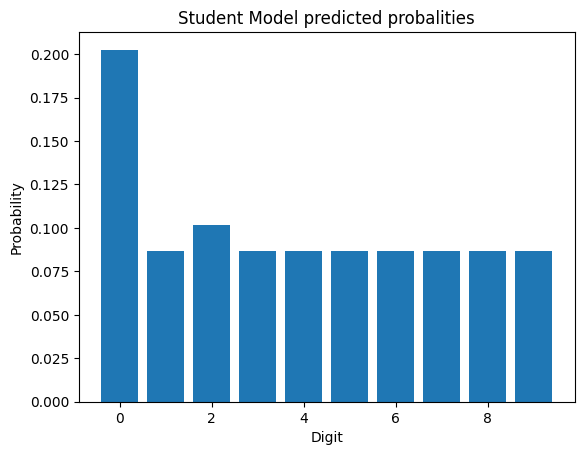

In [77]:
#make a prediction on the orginal image
teacher_output = teacher_model(x_adv)
#apply softmax
teacher_output = F.softmax(teacher_output, dim=1)
#convert to numpy array
teacher_output = teacher_output.detach().numpy()
#plot student output
plt.bar(range(10), teacher_output[0])
plt.xlabel('Digit')
plt.ylabel('Probability')
plt.title("Teacher Model predicted probalities")
plt.show()

student_output = student_model(x_adv)
# apply softmax
student_output = F.softmax(student_output, dim=1)
# convert to numpy array
student_output = student_output.detach().numpy()

# plot student output
plt.bar(range(10), student_output[0])
plt.xlabel('Digit')
plt.ylabel('Probability')
plt.title("Student Model predicted probalities")
plt.show()
